In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
from scipy.integrate import quad
from scipy.interpolate import UnivariateSpline
import seaborn as sns
from scipy.special import factorial
import math
from iminuit import cost, Minuit 
import numpy as np
import pickle

sns.set_context('talk', font_scale=1.0)
sns.set_palette('colorblind')

from depth_helpers import *

Cs_line = source_dict['Cs137']

datpath = '/home/cosilab/CalibrationData/CalibratedDATs/'
plot_dir = '/home/cosilab/CalibrationData/figures/'

In [3]:
files = [['20231103_Am241_AC_600V.dat', '20231109_Am241_AC_600V.dat'], \
         ['20231103_Am241_DC_600V_1.dat', '20231108_Am241_DC_600V_1.dat', '20231103_Am241_DC_600V_2.dat', '20231108_Am241_DC_600V_2.dat']]

erange = [50., 64.]

emin = erange[0]
emax = erange[1]
bins = int((emax-emin) * 4)

AC_centroid_map = np.zeros((2, 37, 37))
DC_centroid_map = np.zeros_like(AC_centroid_map)

fullpaths = []
for p in files[0]:
    fullpaths.append(datpath + 'postLL1/' + p)

df_AC = make_df_from_dat(fullpaths, e_min=emin, e_max=emax)

fullpaths = []
for p in files[1]:
    fullpaths.append(datpath + 'postLL1/' + p)

df_DC = make_df_from_dat(fullpaths, e_min=emin, e_max=emax)

## Post LL1

In [4]:
for p in range(37):
    for n in range(37):
            AC_sliced = df_AC.loc[(df_AC['strip_p']==p+1) & (df_AC['strip_n']==n+1)]
            DC_sliced = df_DC.loc[(df_DC['strip_p']==p+1) & (df_DC['strip_n']==n+1)]
            
            if (len(AC_sliced) > 1000) & (len(DC_sliced) > 1000):
                
                for i, side in enumerate(['p','n']):
                    energies = AC_sliced['energy_' + side].values
                    energies = energies[(energies<emax) & (energies > emin)]
                    
                    c = cost.UnbinnedNLL(energies, gauss_plus_tail_pdf)

                    m = Minuit(c, BoverA=0.5, x0=60., sigma_gauss=1.2, gamma=global_gamma, CoverB=global_CoverB, D=global_D, sigma_ratio=global_sigma_ratio, Emin=emin, Emax=emax)
                    m.limits["BoverA", "sigma_gauss"] = (0, None)
                    m.fixed["gamma", "CoverB", "D", "sigma_ratio", "Emin", "Emax"] = True
                    m.migrad()
                    # m.hesse()
                    # print(m)
                    AC_centroid_map[i][p][n] = m.values['x0']
                    
                    energies = DC_sliced['energy_' + side].values
                    energies = energies[(energies<emax) & (energies > emin)]
                    
                    c = cost.UnbinnedNLL(energies, gauss_plus_tail_pdf)

                    m = Minuit(c, BoverA=0.5, x0=60., sigma_gauss=1.2, gamma=global_gamma, CoverB=global_CoverB, D=global_D, sigma_ratio=global_sigma_ratio, Emin=emin, Emax=emax)
                    m.limits["BoverA", "sigma_gauss"] = (0, None)
                    m.fixed["gamma", "CoverB", "D", "sigma_ratio", "Emin", "Emax"] = True
                    m.migrad()
                    # m.hesse()
                    # print(m)
                    DC_centroid_map[i][p][n] = m.values['x0']
    

/home/cosilab/COSITrapping/depth_helpers.py:57: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad(gauss_plus_tail, Emin, Emax, args=(BoverA, x0, sigma_gauss, gamma, CoverB, D, sigma_ratio))[0]
/home/cosilab/COSITrapping/depth_helpers.py:56: RuntimeWarning: invalid value encountered in divide
  return gauss_plus_tail(x, BoverA, x0, sigma_gauss, gamma, CoverB, D, sigma_ratio)/\
/home/cosilab/COSITrapping/depth_helpers.py:42: RuntimeWarning: overflow encountered in exp
  return (np.exp(gamma*(x-x0)))
/home/cosilab/COSITrapping/depth_helpers.py:57: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain fr

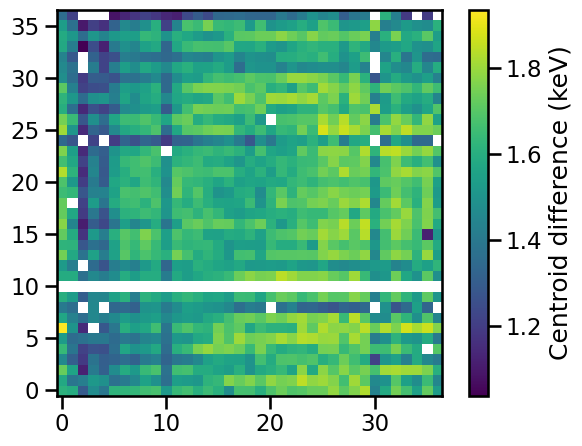

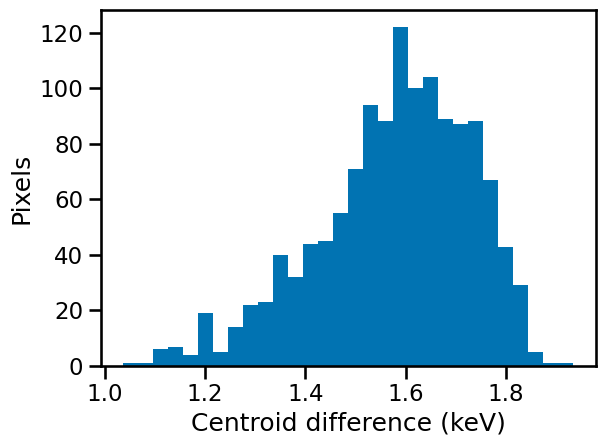

In [5]:
centroid_diff_map = np.ma.masked_outside(DC_centroid_map[1] - AC_centroid_map[1], 0.1,2.3)

plt.figure()
plt.imshow(centroid_diff_map.T, origin='lower')
plt.colorbar(label = 'Centroid difference (keV)')
plt.tight_layout()
plt.savefig(plot_dir + 'postLL1/Am241_ACDC_diff_map_holes.pdf')

plt.figure()
plt.hist(centroid_diff_map.flatten(), bins = 30)
plt.ylabel('Pixels')
plt.xlabel('Centroid difference (keV)')
plt.tight_layout()
plt.savefig(plot_dir + 'postLL1/Am241_ACDC_diff_hist_holes.pdf')

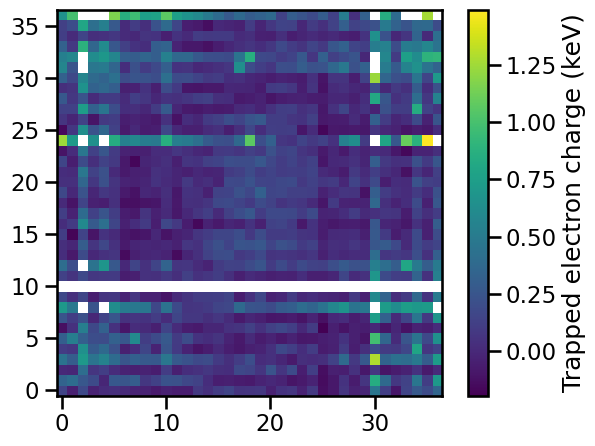

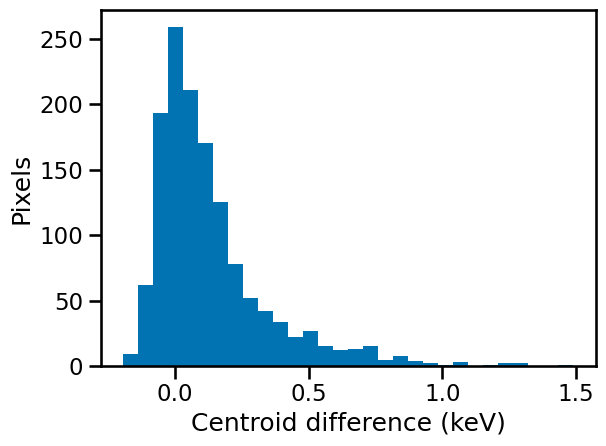

In [6]:
centroid_diff_map = np.ma.masked_equal(AC_centroid_map[0] - DC_centroid_map[0], 0.0)
centroid_diff_map = np.ma.masked_greater(centroid_diff_map, 2.0)

plt.figure()
plt.imshow(centroid_diff_map.T, origin='lower')
plt.colorbar(label = 'Trapped electron charge (keV)')
plt.tight_layout()
plt.savefig(plot_dir + 'postLL1/Am241_ACDC_diff_map_electrons.pdf')

plt.figure()
plt.hist(centroid_diff_map.flatten(), bins = 30)
plt.ylabel('Pixels')
plt.xlabel('Centroid difference (keV)')
plt.tight_layout()
plt.savefig(plot_dir + 'postLL1/Am241_ACDC_diff_hist_electrons.pdf')

## Pre LL

In [7]:
files = [['20230920_Am241_AC_600V.dat', '20231026_Am241_AC_600V.dat'], \
                      ['20230922_Am241_DC_600V_1.dat', '20230922_Am241_DC_600V_2.dat']]

erange = [50., 64.]

emin = erange[0]
emax = erange[1]
bins = int((emax-emin) * 4)

AC_centroid_map = np.zeros((2, 37, 37))
DC_centroid_map = np.zeros_like(AC_centroid_map)

fullpaths = []
for p in files[0]:
    fullpaths.append(datpath + 'preLL/' + p)

df_AC = make_df_from_dat(fullpaths, e_min=emin, e_max=emax)

fullpaths = []
for p in files[1]:
    fullpaths.append(datpath + 'preLL/' + p)

df_DC = make_df_from_dat(fullpaths, e_min=emin, e_max=emax)

In [8]:
for p in range(37):
    for n in range(37):
            AC_sliced = df_AC.loc[(df_AC['strip_p']==p+1) & (df_AC['strip_n']==n+1)]
            DC_sliced = df_DC.loc[(df_DC['strip_p']==p+1) & (df_DC['strip_n']==n+1)]
            
            if (len(AC_sliced) > 1000) & (len(DC_sliced) > 1000):
                
                for i, side in enumerate(['p','n']):
                    energies = AC_sliced['energy_' + side].values
                    energies = energies[(energies<emax) & (energies > emin)]
                    
                    c = cost.UnbinnedNLL(energies, gauss_plus_tail_pdf)

                    m = Minuit(c, BoverA=0.5, x0=60., sigma_gauss=1.2, gamma=global_gamma, CoverB=global_CoverB, D=global_D, sigma_ratio=global_sigma_ratio, Emin=emin, Emax=emax)
                    m.limits["BoverA", "sigma_gauss"] = (0, None)
                    m.fixed["gamma", "CoverB", "D", "sigma_ratio", "Emin", "Emax"] = True
                    m.migrad()
                    # m.hesse()
                    # print(m)
                    AC_centroid_map[i][p][n] = m.values['x0']
                    
                    energies = DC_sliced['energy_' + side].values
                    energies = energies[(energies<emax) & (energies > emin)]
                    
                    c = cost.UnbinnedNLL(energies, gauss_plus_tail_pdf)

                    m = Minuit(c, BoverA=0.5, x0=60., sigma_gauss=1.2, gamma=global_gamma, CoverB=global_CoverB, D=global_D, sigma_ratio=global_sigma_ratio, Emin=emin, Emax=emax)
                    m.limits["BoverA", "sigma_gauss"] = (0, None)
                    m.fixed["gamma", "CoverB", "D", "sigma_ratio", "Emin", "Emax"] = True
                    m.migrad()
                    # m.hesse()
                    # print(m)
                    DC_centroid_map[i][p][n] = m.values['x0']
    

/home/cosilab/COSITrapping/depth_helpers.py:57: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad(gauss_plus_tail, Emin, Emax, args=(BoverA, x0, sigma_gauss, gamma, CoverB, D, sigma_ratio))[0]


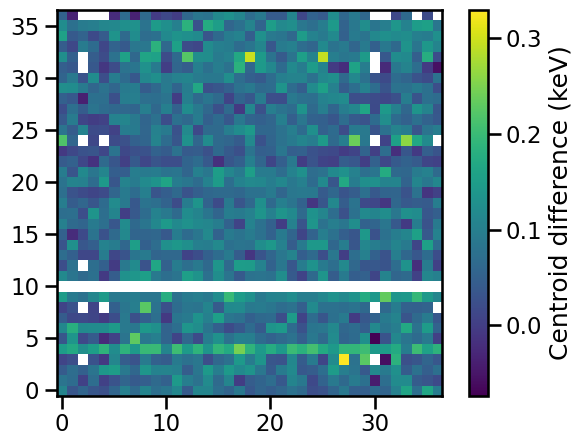

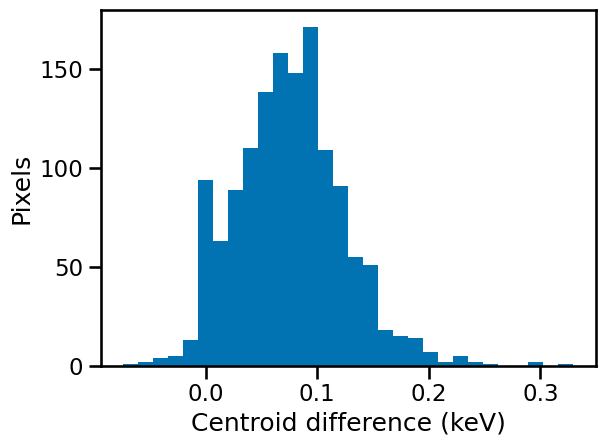

In [9]:
centroid_diff_map = np.ma.masked_equal(DC_centroid_map[1] - AC_centroid_map[1], 0.0)

plt.figure()
plt.imshow(centroid_diff_map.T, origin='lower')
plt.colorbar(label = 'Centroid difference (keV)')
plt.tight_layout()
plt.savefig(plot_dir + 'preLL/Am241_ACDC_diff_map_holes.pdf')

plt.figure()
plt.hist(centroid_diff_map.flatten(), bins = 30)
plt.ylabel('Pixels')
plt.xlabel('Centroid difference (keV)')
plt.tight_layout()
plt.savefig(plot_dir + 'preLL/Am241_ACDC_diff_hist_holes.pdf')

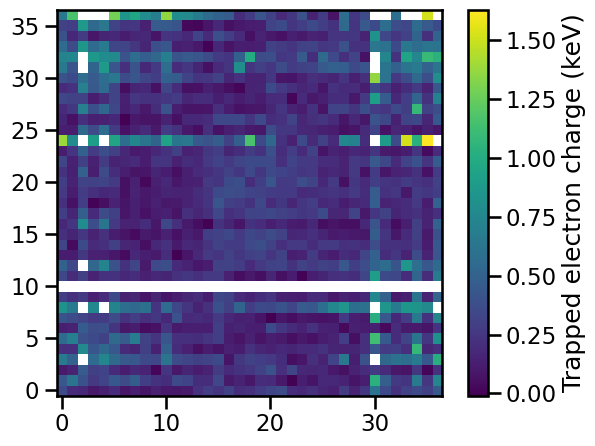

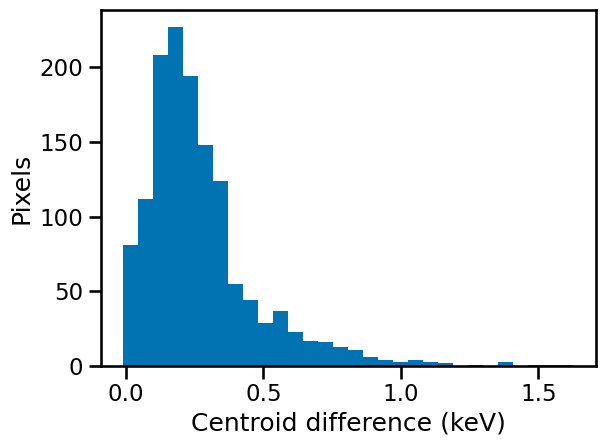

In [10]:
centroid_diff_map = np.ma.masked_equal(AC_centroid_map[0] - DC_centroid_map[0], 0.0)
centroid_diff_map = np.ma.masked_greater(centroid_diff_map, 2.0)

plt.figure()
plt.imshow(centroid_diff_map.T, origin='lower')
plt.colorbar(label = 'Trapped electron charge (keV)')
plt.tight_layout()
plt.savefig(plot_dir + 'preLL/Am241_ACDC_diff_map_electrons.pdf')

plt.figure()
plt.hist(centroid_diff_map.flatten(), bins = 30)
plt.ylabel('Pixels')
plt.xlabel('Centroid difference (keV)')
plt.tight_layout()
plt.savefig(plot_dir + 'preLL/Am241_ACDC_diff_hist_electrons.pdf')